In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/clay/userdata/title_generation


In [3]:
import torch
import shutil
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from data_utils import ABCset, MeasureNumberSet, pack_collate, PitchDurSplitSet, FolkRNNSet, MeasureOffsetSet, read_yaml, MeasureEndSet, get_emb_total_size
from emb_trainer import EmbTrainer, EmbTrainerMeasure, EmbTrainerMeasureMRR
from emb_loss import get_batch_contrastive_loss, get_batch_euclidean_loss, clip_crossentropy_loss
from emb_utils import pack_collate_title_sampling_train, pack_collate_title_sampling_valid
from torch.nn import CosineEmbeddingLoss

import data_utils
import model_zoo
import emb_model
import emb_data_utils
import vocab_utils

import argparse
import wandb
import datetime

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = Path('pre_trained/measure_note_xl/')
if path.is_dir():
  yaml_path = list(path.glob('*.yaml'))[0]
  vocab_path = list(path.glob('*vocab.json'))[0]
  checkpoint_list = list(path.glob('*.pt'))
  checkpoint_list.sort(key= lambda x: int(x.stem.split('_')[-2].replace('iter', '')))
  checkpoint_path = checkpoint_list[-1]
  config = data_utils.read_yaml(yaml_path)
  data_param = config.data_params
  model_name = config.nn_params.model_name
  vocab_name = config.nn_params.vocab_name
  net_param = config.nn_params
  vocab = getattr(vocab_utils, vocab_name)(json_path= vocab_path)
  config = data_utils.get_emb_total_size(config, vocab)

In [5]:
score_dir = Path('abc_dataset/folk_rnn_abc_key_cleaned_for_title/')
dataset_name_ttl = "ABCsetTitle_22K"
dataset_abc = getattr(emb_data_utils, dataset_name_ttl)(score_dir, vocab_path, make_vocab=False, key_aug=data_param.key_aug, vocab_name=net_param.vocab_name, tune_length=100)
dataset_abc.vocab = vocab

Error in token measure_offset: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in meas_offset_from_repeat_start: <Beam "|:">


In [6]:
model_cnn_reducedemb = getattr(emb_model, 'ABC_cnn_emb_Model')(trans_emb=None, vocab_size=vocab.get_size(), net_param=net_param, emb_size=256, hidden_size=128, emb_ratio=1)
model_ttl = getattr(emb_model, 'TTLembModel')(emb_size=256)

# load pretrained model
model_cnn_reducedemb.load_state_dict(torch.load('/home/clay/userdata/title_generation/saved_models/0130_06_transfer_best/measurenote_0.pt')['model'])
model_ttl.load_state_dict(torch.load('/home/clay/userdata/title_generation/saved_models/0130_06_transfer_best/ttlemb_0.pt')['model'])

model_cnn_reducedemb
model_ttl

RuntimeError: Error(s) in loading state_dict for ABC_cnn_emb_Model:
	size mismatch for conv_layer.0.weight: copying a param with shape torch.Size([128, 2624, 1]) from checkpoint, the shape in current model is torch.Size([256, 2624, 1]).
	size mismatch for conv_layer.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for conv_layer.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for conv_layer.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for conv_layer.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for conv_layer.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for conv_layer.3.weight: copying a param with shape torch.Size([128, 128, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3]).

In [ ]:
torch.manual_seed(42)

trainset, validset = torch.utils.data.random_split(dataset_abc, [int(len(dataset_abc)*0.9), len(dataset_abc) - int(len(dataset_abc)*0.9)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainset, batch_size=7000, collate_fn=pack_collate_title_sampling_train, shuffle=True) #collate_fn=pack_collate)
valid_loader = DataLoader(validset, batch_size=7000, collate_fn=pack_collate_title_sampling_valid, shuffle=False) #collate_fn=pack_collate)


In [15]:
for batch in train_loader:
  melody, title, measure_numbers = batch
  train_abc_emb = model_cnn_reducedemb(melody.to('cuda'), measure_numbers.to('cuda'))
  train_ttl_emb = model_ttl(title.to('cuda'))

: 

: 

In [1]:
for batch in valid_loader:
  melody, title, measure_numbers = batch
  valid_abc_emb = model_cnn_reducedemb(melody.to('cuda'), measure_numbers.to('cuda'))
  valid_ttl_emb = model_ttl(title.to('cuda'))

NameError: name 'valid_loader' is not defined

In [22]:
train_ttl_emb = train_ttl_emb.detach().cpu().numpy()
train_abc_emb = train_abc_emb.detach().cpu().numpy()
valid_ttl_emb = valid_ttl_emb.detach().cpu().numpy()
valid_abc_emb = valid_abc_emb.detach().cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [28]:
# Concatenate all the datasets along the first dimension (axis 0)
all_emb = np.concatenate((train_ttl_emb, train_abc_emb, valid_ttl_emb, valid_abc_emb), axis=0)

# Initialize UMAP reducer
# reducer = umap.UMAP(n_components=2)
# reducer = PCA(n_components=2)
reducer = TSNE(n_components=2)

# Fit and transform the concatenated data
all_emb_2D = reducer.fit_transform(all_emb)

# Split the 2D data into 4 parts
train_ttl_emb_2D, train_abc_emb_2D, valid_ttl_emb_2D, valid_abc_emb_2D = np.split(all_emb_2D, [len(train_ttl_emb), len(train_ttl_emb) + len(train_abc_emb), len(train_ttl_emb) + len(train_abc_emb) + len(valid_ttl_emb)])

/home/clay/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


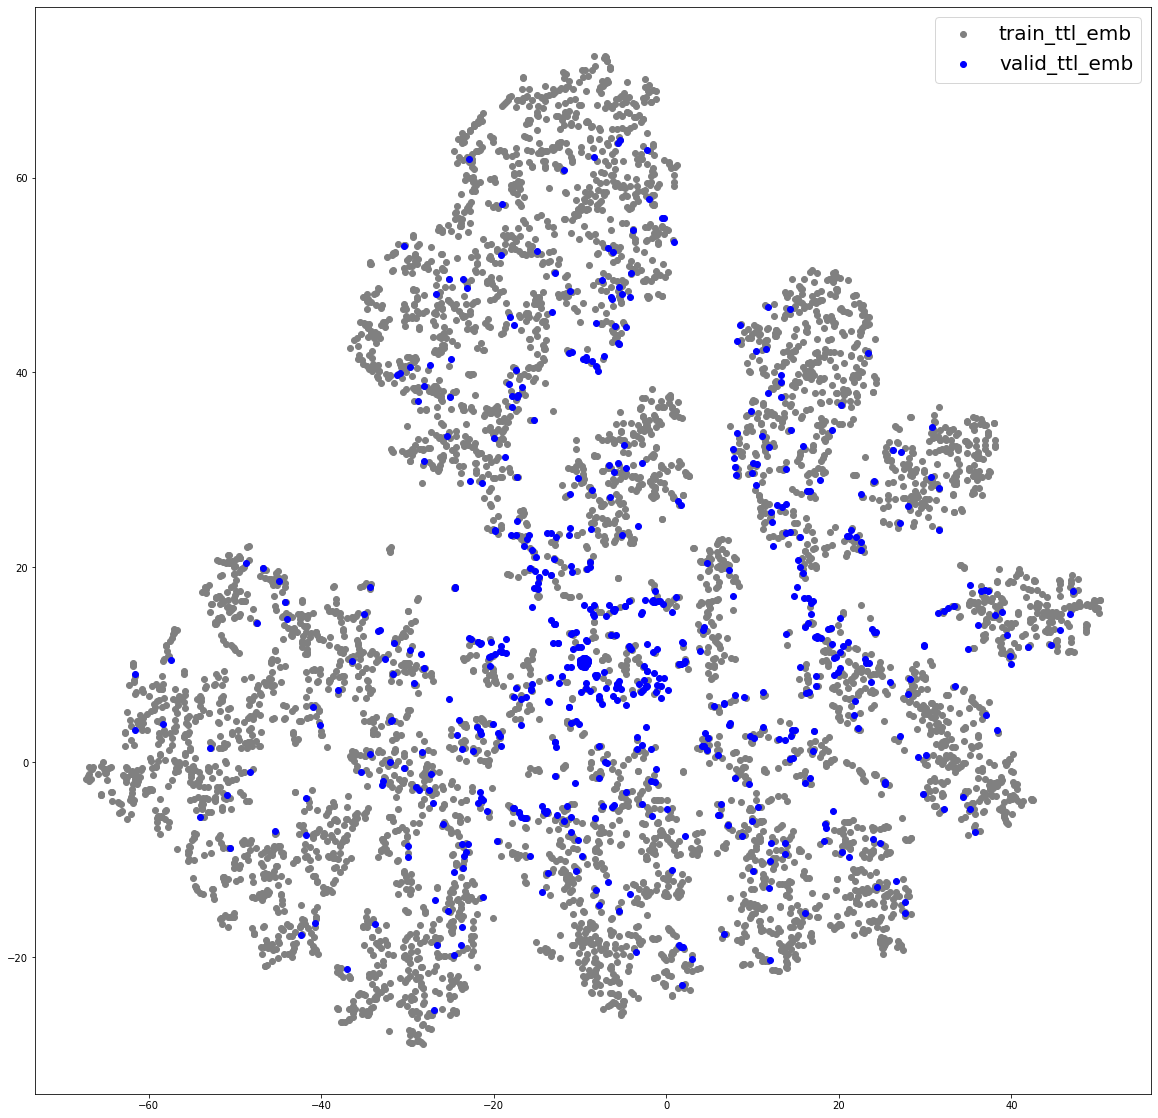

In [29]:
idxs_train = np.arange(len(train_ttl_emb_2D))
idxs_valid = np.arange(len(valid_ttl_emb_2D))

x_train = train_ttl_emb_2D[idxs_train, 0]
y_train = train_ttl_emb_2D[idxs_train, 1]
x_valid = valid_ttl_emb_2D[idxs_valid, 0]
y_valid = valid_ttl_emb_2D[idxs_valid, 1]

fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_train, y_train, c='grey', label='train_ttl_emb')
ax.scatter(x_valid, y_valid, c='b', label='valid_ttl_emb')
ax.legend(fontsize=20)

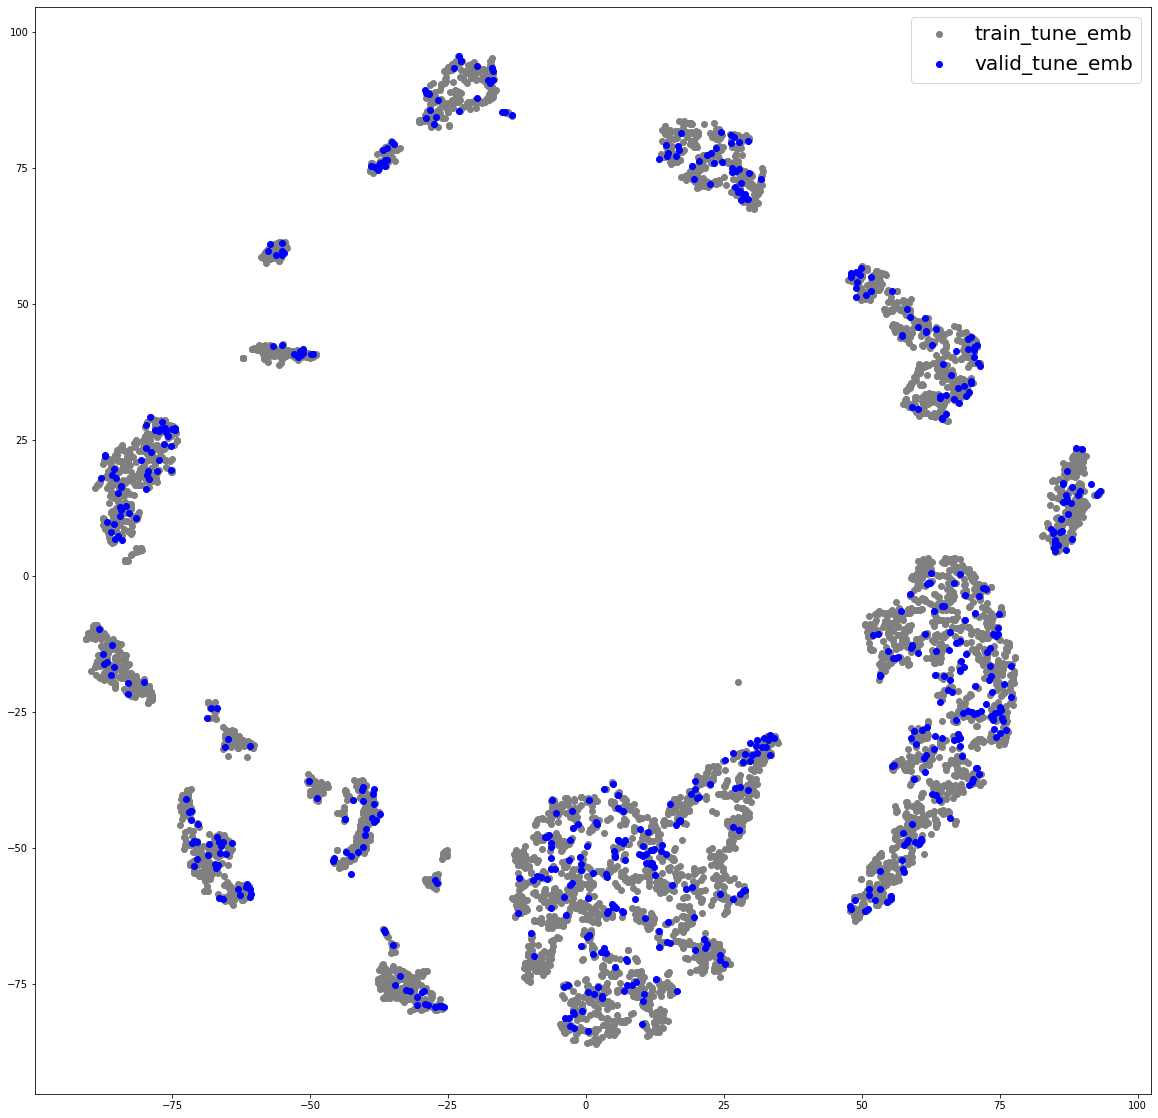

In [30]:
idxs_train = np.arange(len(train_ttl_emb_2D))
idxs_valid = np.arange(len(valid_ttl_emb_2D))

x_train = train_abc_emb_2D[idxs_train, 0]
y_train = train_abc_emb_2D[idxs_train, 1]
x_valid = valid_abc_emb_2D[idxs_valid, 0]
y_valid = valid_abc_emb_2D[idxs_valid, 1]

fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_train, y_train, c='grey', label='train_tune_emb')
ax.scatter(x_valid, y_valid, c='b', label='valid_tune_emb')
ax.legend(fontsize=20)

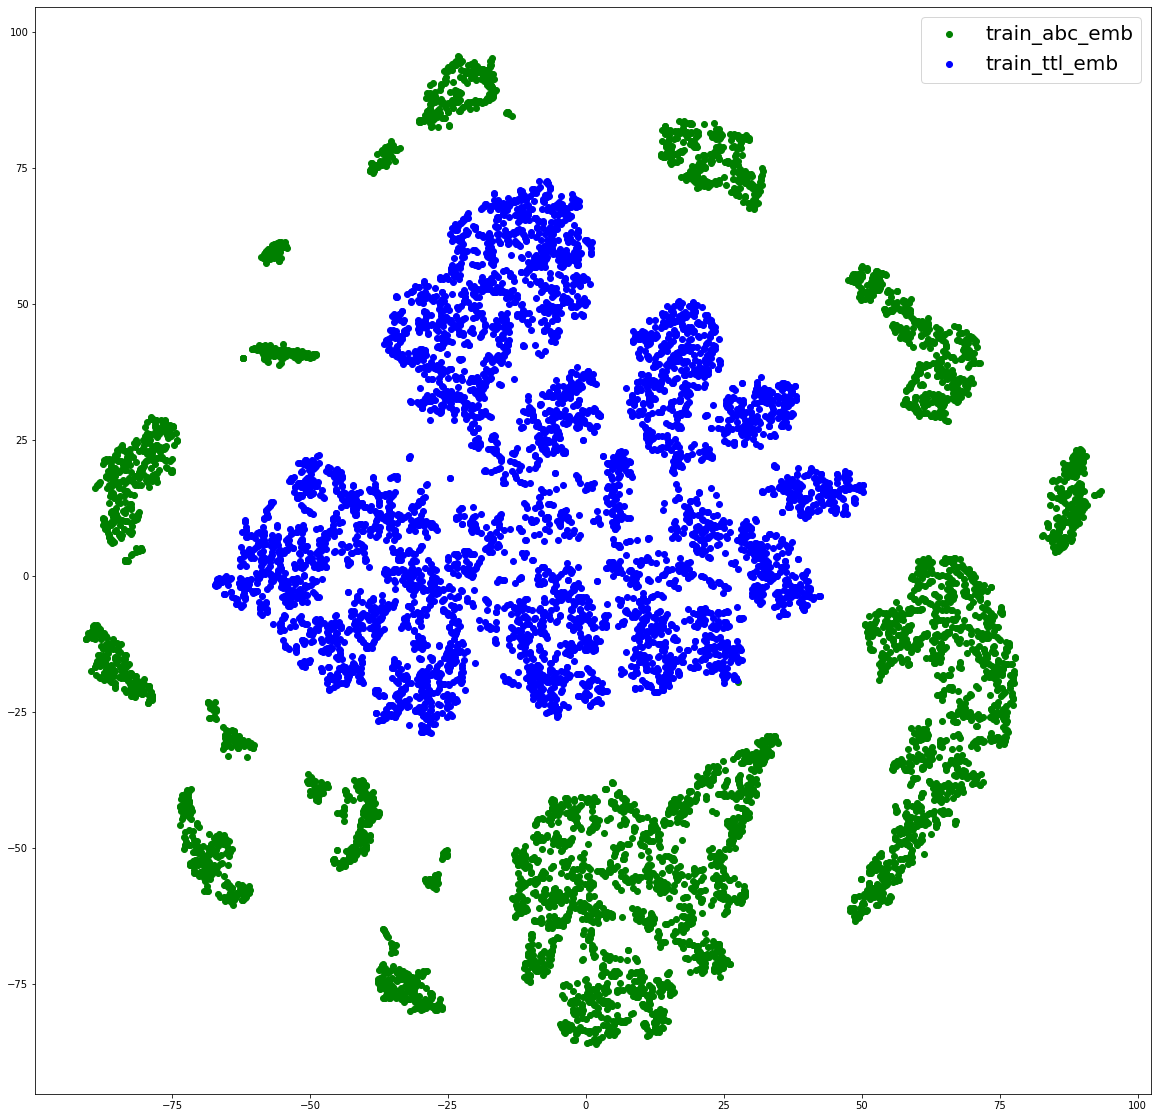

In [31]:
idxs_train = np.arange(len(train_ttl_emb_2D))
idxs_valid = np.arange(len(valid_ttl_emb_2D))

x_train = train_abc_emb_2D[idxs_train, 0]
y_train = train_abc_emb_2D[idxs_train, 1]
x_valid = train_ttl_emb_2D[idxs_train, 0]
y_valid = train_ttl_emb_2D[idxs_train, 1]

fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_train, y_train, c='green', label='train_abc_emb')
ax.scatter(x_valid, y_valid, c='b', label='train_ttl_emb')
ax.legend(fontsize=20)

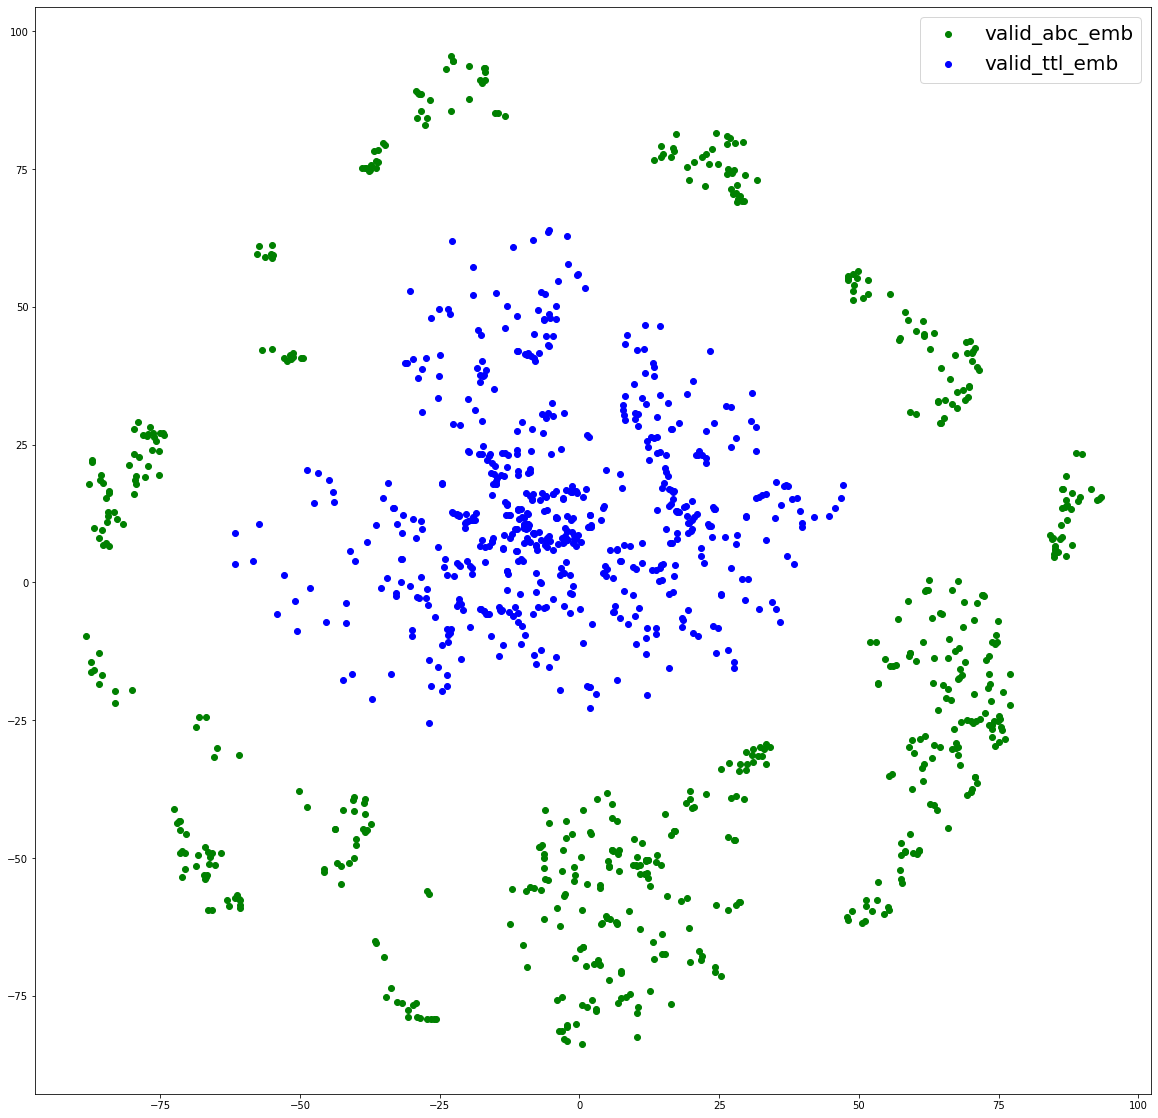

In [32]:
idxs_train = np.arange(len(train_ttl_emb_2D))
idxs_valid = np.arange(len(valid_ttl_emb_2D))

x_train = valid_abc_emb_2D[idxs_valid, 0]
y_train = valid_abc_emb_2D[idxs_valid, 1]
x_valid = valid_ttl_emb_2D[idxs_valid, 0]
y_valid = valid_ttl_emb_2D[idxs_valid, 1]

fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_train, y_train, c='green', label='valid_abc_emb')
ax.scatter(x_valid, y_valid, c='b', label='valid_ttl_emb')
ax.legend(fontsize=20)